Данный блокнот содержит все имеющиеся на текущий момент сведения по работе над датасетом первых воспоминаний 'reminiscence'.

Вопросы исследования

Черновой план дальнейшей работы:
- Аналогично Мотив, Ориентир возраста обработать остальные текстовые разделы - заранее - это позволяет сконцентрироваться на конкретных определениях
- Для игрушек можно собрать какие разные игрушки были у детей советского времени и девяностых годов - описание игрушки (игрушка)
- Инструмент, который позволяет быстро генерировать объекты ссылок для текста - функция, принимающая название столбца и строку, входящую в ячейку
- Было бы полезно подробнее рассказать о сборе воспоминаний - какие номера какому типу сбора соответствуют, где был их источник - воспоминания 469-643 собраны преимущественно через Google-форму. 
- Преобразование в pandas строковых значений чисел в числовые
- Описать разделы построений распределений для каждой категории таблицы
- Построение распределения возрастов всех воспоминаний (не минимальных)
- Инструмент для объектов вида "объект (общая группа объектов)"
- Было бы удобно, если бы исходный датафрейм был глобальной переменной
- Распределения записей по числовым параметрам:
    - Возраст (общий инструмент для разных граф - с целью построения корреляций). Для пары "возраст-воспоминание" имеет смысл построить распределения самых ранних воспоминаний, если указан диапазон - то указывать среднюю точку с интервалом ()
    - Активное-пассивное
    - Наличие/отсутствие лиц и вообще инструмент заполненности поля (сколько символов "-" и сколько заполненных)
- pymorphy: разбивать составные воспоминания по отступу в виде одной строки или специальному символу. Отношение между частями речи. Что преобладает в коротких воспоминаниях? Анализ по парам младший/старший, мама/пара, бабушка/дедушка.
- pymorhy:
- Функция генерации текста из чередующихся "малых" и "крупных" воспоминаний для облегчения чтения в виде текста

# Считывание данных из Google Sheet

Набор данных оформлен [в виде электронной таблицы на Google Drive](https://docs.google.com/spreadsheets/d/1KSirtO9hZSmVst--GiqsBPYk6hX-xOCI-SolgiafjcI/edit?usp=sharing). Доступ к Google Sheets API осуществляется в соответствии с [документацией API для Python](https://developers.google.com/sheets/api/quickstart/python).

Импортируем данные учетной записи и преобразуем в объект Pandas:

In [1]:
%matplotlib inline

# встроенные
import json
import os.path
import pickle       # хранение токенов
import collections  # используется для подсчета
import re           # обработка текстовой составляющей

# сторонние
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pymorphy2    # обработка текстовой составляющей
    
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
SPREADSHEET_ID = '1KSirtO9hZSmVst--GiqsBPYk6hX-xOCI-SolgiafjcI' # id гугл-таблицы
RANGE_NAME = 'Memories' # Забираем лист целиком диапазон

In [2]:
def get_data():
    """Авторизует и забирает данные из Google SpreadSheet"""
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
    values = result.get('values', [])

    if not values:
        print('No data found.')
    
    return values

## Обработка данных в Pandas

Создаем датафрейм. Удаляем те строки, что не относятся к датасету (комментарии в конце файла)

In [3]:
def get_df():
    data = get_data()
    df = pd.DataFrame.from_records(data)
    headers = df.iloc[0]  # Названия столбцов содержатся в нулевой строке таблицы
    df = pd.DataFrame(df.values[1:], columns=headers)
    df = df.set_index('№') # Номер строки соответствует номеру воспоминания
    
    # Пока не рассматриваются переводные записи. Комментарии используются лишь как заметки
    df = df.drop(columns=['Name', 'Translation', 'Translation footnote', 'Комментарий'])
    
    # Добавим столбец подсчета числа символов, из которых состоит запись.
    df ['Число символов'] = df['Воспоминание'].apply(lambda x: len(x))
    return df
    
df = get_df()

Для обзора датасета создадим функции подсчета числа пустых ячеек определенного поля, а также вывода необработанной части датасета в порядке возрастания объема записи.

In [4]:
def col_empty_cells(df, col_name:str):
    """Находит пустые и NoneType ячейки столбца с именем col_name"""
    none_cells = df[col_name][~df[col_name].notna()].index
    empty_cells = df[col_name][df[col_name]==''].index
    ids = sorted(list(set(none_cells) | set(empty_cells)))
    return ids

#! Откорректировать так, чтобы учитывались одиночные пустые ячейки
def percent_line():
    df = get_df()
    """Определяет долю полностью обработанных записей, не содержащие пустых строк во всех полях,
    за исключением графы Комментарий. Выводятся строки, в порядке возрастания объема воспоминания"""
    # отбираем записи, содержащие не более 1 пустой графы - обычно это графа комментарий 
    df_not_ready = df[df.apply(lambda x: x.isnull().sum(), axis='columns') > 0]
    p = 100*(1-len(df_not_ready)/len(df))
    print("Осталось обработать целиком записей: {0}, подготовлено {1:.1f}% датасета.".format(len(df_not_ready), p))
    return df_not_ready.sort_values(by='Число символов').head(10)

In [5]:
percent_line()

Осталось обработать целиком записей: 7, подготовлено 99.0% датасета.


,Имя,Воспоминание,Пол,Кол-во,Возраст,Ориентир возраста,Мотив,Лица,Предметы,Цвета,Звуки,"Запахи, вкус",Другие ощущения,Сущности,Пространство,Время дня,Время года,Поведение,Число символов
№,,,,,,,,,,,,,,,,,,,
673,Саша,"Как я играл с игрушкой (собачка-пищалка), и ду...",м,1,2-2.5,,,,собачка-пищалка (игрушка),None,None,None,None,None,None,None,None,None,126
671,Оля,"Я совсем маленькая (не больше двух лет), укута...",ж,1,2,None,None,None,None,None,None,None,None,None,None,None,None,None,212
669,Саша,"Я в парке, бегу к маме по асфальту, по дороге ...",ж,3,3;4-5;6,None,None,None,None,None,None,None,None,None,None,None,None,None,229
674,Алёна,Вся комната залита рыжим светом. Мы еще живем ...,ж,1,2-3,место проживания,,,разбитый градусник,None,None,None,None,None,None,None,None,None,289
672,Тимур,Папа гуляет со мной на заднем дворе дома в Мос...,м,3,1.5;4;4,None,None,None,None,None,None,None,None,None,None,None,None,None,475
668,Настя,Тактильное воспоминание металлических ручек ко...,ж,2,1;3-4,None,None,None,None,None,None,None,None,None,None,None,None,None,552
670,Лена,"Я стою в углу в детской, зима и вечер, шторы з...",ж,6,<5; 4,None,None,None,None,None,None,None,None,None,None,None,None,None,2121


# Функции предварительной обработки набора данных

In [6]:
#! поиск дубликатов
print('Число дублирующихся записей в датасете: {}.'.format(len(df[df.duplicated()==True])))

Число дублирующихся записей в датасете: 0.


# Исследование распределений

Полностью заполнена лишь графа, содержащая текст воспоминания. Для указания того, что в тексте воспоминания не имеется дополнительной информации, указывает знак "-" (минус). Для анализа полноты используется функция `minus_or_smth_dstrb`.

In [7]:
def minus_or_smth(col_name: str):
    """Выводит число пустых ячеек, ячеек с символом минус и ячеек, содержащих информацию"""
    empty_cell_ids = col_empty_cells(df, col_name)
    print('Число пустых ячеек: {}.'.format(len(empty_cell_ids)))
    df_essential = df.drop(empty_cell_ids)
    column_essential = df_essential[col_name]
    minus_cell_ids = column_essential[column_essential=='-'] 
    print('Число записей, не содержащих информации про {}: {}.'.format(col_name.lower(), len(minus_cell_ids)))
    plus_cell_ids = column_essential[column_essential!='-']
    print('Число записей, содержащих информацию про {}: {}.'.format(col_name.lower(), len(plus_cell_ids)))
    return empty_cell_ids, minus_cell_ids, plus_cell_ids


## Гендерное распределение

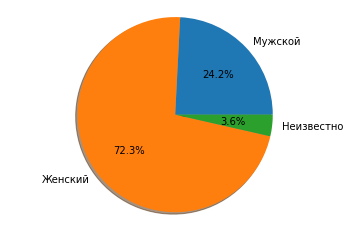

In [8]:
labels = ["Мужской", "Женский", "Неизвестно"]
sizes = [sum(df['Пол']==i) for i in ['м', 'ж', '-']]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

Выборка смещена. Иногда мужчины также отвечали, что не могут ничего вспомнить.

## Распределение возраста

Возраста приводятся в форме приблизительного или точного (при соотнесении с событием) возраста, либо интервала. Интервалы в формате `начало диапазона-конец диапазона` приводим в форму двух чисел. Также имеются описания в которых используются не отрезки, а "лучи" времени (например, "не позже пяти", "после трех лет"). Все виды записей возраста представляются в виде списка словарей с ключами `float`, `range`, `more`, `less`.

In [9]:
#! некорректно обрабатывается строка вида '0.41-0.58; <1'
def age(age_str:'str'):
    '''Возвращает список разбитых на категории возрастов воспоминаний'''
    list_of_ages = []
    
    def age_float(s:'str'):
        list_of_ages.append({'float': float(s)})
    
    def age_range(s:'str'):
        r = [float(item) for item in s.split('-')]
        list_of_ages.append({'range': r})
        
    def age_not_single(s:str):
        if '-' in s:
            age_range(s)
        elif '<' in s:
            list_of_ages.append({'less': float(s[1:])})
        elif '>' in s:
            list_of_ages.append({'more': float(s[1:])})
        else:
            age_float(s)
    
    try:
        age_float(age_str)
    except ValueError:  #!! здесь блоки лучше заменить рекурсией или вызовом функции
        if ';' in age_str:
            for s in age_str.split(';'):
                age_not_single(s)
        else:
            age_not_single(age_str)
    
    return list_of_ages

In [10]:
age_df = df.loc[minus_or_smth('Возраст')[2].index]
age_df['age'] = age_df['Возраст'].apply(lambda x: age(x))

def age_dst_rough(age_list:list):
    '''Метод грубого разбиения возрастов:
    для диапазона используются средние значения интервалов,
    для лучевых отрезков (больше, меньше) - крайние точки'''
    age_rough_list = []
    for d in age_list:
        if 'float' in d:
            age = d['float']
        elif 'range' in d:
            age = sum(d['range'])/2
        elif 'less' in d:
            age = d['less']
        elif 'more' in d:
            age = d['more']
        else:
            age = None
        age_rough_list.append(age)
    return age_rough_list

# грубое разбиение возрастов
age_df['age'].apply(lambda x: age_dst_rough(x))

# минимальный возраст среди нескольких воспоминаний
age_df['min_age'] = age_df['age'].apply(lambda x: min(age_dst_rough(x)))

Число пустых ячеек: 0.
Число записей, не содержащих информации про возраст: 75.
Число записей, содержащих информацию про возраст: 599.


ValueError: could not convert string to float: '1.33,1.25'

KeyError: 'min_age'

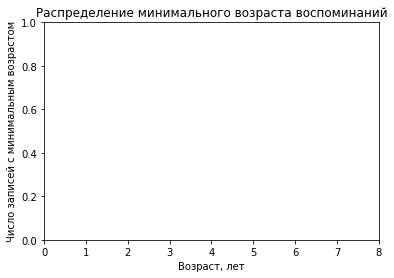

In [11]:


plt.title('Распределение минимального возраста воспоминаний')
plt.xticks(range(0, 9))
plt.xlabel('Возраст, лет')
plt.ylabel('Число записей с минимальным возрастом')
plt.hist(age_df['min_age'], bins=20)
plt.show()

## Уточнение возраста

Во многих случаях возраст не указан, но из самого текста воспоминания можно определить возрастаные границы. Маркерами возраста служат навыки, приобретаемые ребенкам. Для того, чтобы считать эти маркеры, можно использовать столбец «Ориентир возраста», в котором есть такие записи как "неумение ходить", "неумение говорить" и т.п.

Еще одним маркером, позволяющим уточнить возраст является то, что многие воспоминания связаны со встречей дня рождения. Это означает, что ребенку исполняется вполне конкретное число лет. В других случаях мы привыкли называть количество $n$ полных лет, но фактически это означает, что возраст представляет интервал $[n ... n+1)$.

Для "негрубого" построения необходимо найти подходящий тип визуализации, учитывающий "размазанность" интервалов.

# Ориентир возраста

In [12]:
df = get_df()

In [13]:
def get_comma_separated_items(column):
    '''Собирает строковые значения, разделенный запятыми в один общий список'''
    item_list = []
    for line in df[column]:
        if line:
            for item in line.split(','):
                item_list.append(item.strip())
    return item_list

In [14]:
cnt_age_orient = collections.Counter(get_comma_separated_items('Ориентир возраста'))
cnt_age_orient.most_common()

[('-', 339),
 ('место проживания', 41),
 ('детский сад', 35),
 ('подтверждение родственников', 31),
 ('день рождения', 25),
 ('крещение', 12),
 ('смерть родственника', 12),
 ('Новый год', 11),
 ('рождение брата/сестры', 11),
 ('неумение ходить', 6),
 ('травма', 6),
 ('фотографии', 5),
 ('операция', 5),
 ('развод родителей', 4),
 ('неумение говорить', 4),
 ('ясли', 3),
 ('рождение', 3),
 ('внутреннее содержание', 3),
 ('обучение ходьбе', 2),
 ('первомайская демонстрация', 2),
 ('болезнь родственника', 2),
 ('отдых', 2),
 ('не спится', 2),
 ('фотография', 2),
 ('стеснение движений', 1),
 ('конкретный ориентир года', 1),
 ('отдых на море', 1),
 ('отъезд отца на заработки', 1),
 ('детский лагерь для малышей', 1),
 ('помощь родителей', 1),
 ('обучение чтению', 1),
 ('поход на байдарках', 1),
 ('ожог', 1),
 ('влюбленность', 1),
 ('первые шаги', 1),
 ('землятресение', 1),
 ('возраст сестры', 1),
 ('смерть', 1),
 ('родители', 1),
 ('похороны', 1),
 ('чувство позднего времени воспоминания', 1),

## Мотив

In [15]:
df = get_df()
cnt_age_orient = collections.Counter(get_comma_separated_items('Мотив'))
cnt_age_orient.most_common()

[('наблюдение', 65),
 ('игра', 41),
 ('прогулка', 39),
 ('на руках', 38),
 ('травма', 34),
 ('животное', 31),
 ('активность', 31),
 ('солнечный свет', 31),
 ('кровать', 24),
 ('встреча дня рождения', 23),
 ('обучение', 19),
 ('сидение', 19),
 ('пробуждение', 16),
 ('игрушка', 16),
 ('испуг', 16),
 ('страх', 15),
 ('предмет', 15),
 ('еда', 14),
 ('телевизор', 13),
 ('крещение', 13),
 ('ложное воспоминание', 13),
 ('стояние', 12),
 ('наблюдение родственника', 12),
 ('впервые', 12),
 ('качание', 11),
 ('смех', 11),
 ('болезнь', 11),
 ('быть везомым', 11),
 ('сон', 11),
 ('бег', 11),
 ('фотографирование', 10),
 ('встреча Нового года', 10),
 ('купание', 10),
 ('операция', 10),
 ('темнота', 10),
 ('мысль', 9),
 ('укутывание', 9),
 ('лежание', 9),
 ('одежда', 8),
 ('движение', 8),
 ('путь до места', 8),
 ('взаимодействие с родственником', 8),
 ('укладывание', 8),
 ('одевание', 8),
 ('переезд', 7),
 ('одежда с рисунком', 7),
 ('предметы', 6),
 ('праздник', 6),
 ('удивление', 6),
 ('плач', 6),


## Предметы

In [ ]:
def del_category_in_brackets(line:str):
    '''Возвращает название объекта без категории,
    приведенной после названия объекта в скобках'''
    index = line.find(' (')
    if index > 0:
        return line[:index]

# Обработка текстуальной составляющей

[Документация pymorphy2](https://pymorphy2.readthedocs.io/en/latest/user/index.html)

## Распределение числа воспоминаний в записях

## Распределение объема воспоминаний
- по числу воспоминаний в записи
- по числу символов, слов, предложений
- по числу предложений, приходящихся на одно воспоминание

### Распределение числа символов в записях

In [16]:
get_df()

,Имя,Воспоминание,Пол,Кол-во,Возраст,Ориентир возраста,Мотив,Лица,Предметы,Цвета,Звуки,"Запахи, вкус",Другие ощущения,Сущности,Пространство,Время дня,Время года,Поведение,Число символов
№,,,,,,,,,,,,,,,,,,,
1,Женя,"Мама поставила меня на стул, лицом к окну, шел...",-,1,4,день рождения,встреча дня рождения,мама,"стул, пижама","красный, белый",голос,-,-,снег,комната,-,зима,пассивное,205
2,-,Мне года полтора. Я беру маленький деревянный ...,-,1,1.5,-,"перенос предмета, наблюдение",-,стульчик,-,-,-,-,"солнечный свет, деревянный, квадрат","коридор, комната",день,-,"активное, пассивное",174
3,Таня,"Оно относится к несчастному возрасту, когда ме...",ж,2,1-3,ясли,"опасность нового места, заимствование предмета","мама, папа",игрушка,-,-,суп,"страх, одиночество",лестница,"ясли, дом",-,-,"пассивное, активное",438
4,Кира,"Помню, как бабушка меня качает, а мама смеется...",ж,1,-,-,"качание, расчесывание волос","бабушка, мама","стол, окно, волосы",седой,смех,-,-,седые длинные волосы,дом,-,-,пассивное,164
5,Настя,"Я лежу в кровати с мамой, позднее утро, выходн...",ж,8,<7,-,"кукла, путь до детсада, травма, приченение тра...","мама, бабушка, злой мальчик, девочка,","кукла, санки, коробка, спица, стеклянный стакан",-,собственный плач,-,"боль, желание иметь брата/сестру, обида, униже...",кровь,"кровать, улица, садик, комната, медицинское уч...","утро, вечер",зима,"активное, пассивное",1254
6,Катя,"Мама пытается меня успокоить, а я от чего-то в...",ж,1,1,-,крик,"мама, папа, сестра","кроватка, игрушки, веревки, пеленки, одежда",-,собственный крик,-,"сияние, тусклый свет духа, крик, разрывающий в...","нагромождение вещей, усталость мамы, фантомнос...",комната,-,-,-,564
7,-,"Как-то давно, когда моя семья еще была целой, ...",ж,1,-,-,"истерика, смех","мама, милицейская парочка","наручники, спичка",-,-,-,"игра, истерика",-,"комната, диванчик",-,-,"активное, пассивное",723
8,Яша,К зиме не помню какого возраста. Снег в свете ...,ж,6,-,-,"травма, еда, боязнь, побег, рисунок, похвала, ...","бабушка, дедушка, мама, папа, кот, кролики, во...","фонарь, безрукавка, икра, алюминиевая ложка, к...","рыжий, желтый, белый, красный, оранжевый, ярко...",-,-,"колючесть одежды, вывих, страх животных, устал...","снег, храм","комната, дача,",вечер,"зима, лето",активное,700
9,-,"Маловероятно, но мне было до года. Потому что ...",ж,1,<1,-,"холод, крик",-,весы,белый,собственный крик,-,ощущение холода,холод,подоконник,-,-,пассивное,321


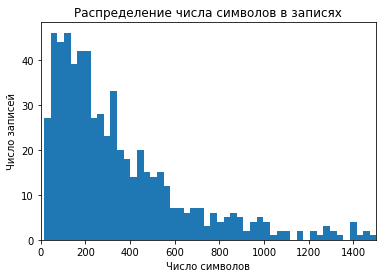

In [17]:
plt.xlim(left=0, right=1500)
plt.title('Распределение числа символов в записях')
plt.xlabel('Число символов')
plt.ylabel('Число записей')
plt.hist(df['Число символов'], bins=200)
plt.show()

## Среднее, минимальное и максимальное число символов, приходящееся на одно воспоминание

## Сколько предложений в среднем приходится на одно воспоминание?

In [18]:
morph = pymorphy2.MorphAnalyzer()
get_df()
one_string = '\n\n'.join(df['Воспоминание'])

In [19]:
# Найдем список всех слов

s = re.sub(r'[^a-zA-Zа-яА-Я0-9- ]', ' ', one_string)
# список всех слов корпуса текста (с повторами, в порядке появления)
words = s.split()  

In [20]:
norm_words = []

for word in words:
    p = morph.parse(word)
    norm_words.append(p[0].normalized.word)

Сравним число исходных и нормализованных слов

In [21]:
l = [len(words), len(set(words)), len(set(norm_words))]
print('Число слов в тексте: {}, с учетом повторов: {}, нормализованных с учетом повторов: {}.'.format(*l))

Число слов в тексте: 42327, с учетом повторов: 10448, нормализованных с учетом повторов: 5860.


Посчитаем число слов, найдем самые распространенные, не относящиеся к союзам, предлогам, местоимениям, частицам и междометиям:

In [22]:
word = 'я'
p = morph.parse(word)
str(p[0].tag.POS)

'NPRO'

In [23]:
import collections

cnt = collections.Counter(norm_words)
not_value_gram = ['NPRO', 'CONJ', 'PREP', 'PRCL', 'INTJ']

# Обнулим счетчик для слов тех частей речи, что относятся к перечисленным
for key in cnt.keys():
    p = morph.parse(key)
    if str(p[0].tag.POS) in not_value_gram:
        cnt[key] = -1
        
print(cnt.most_common(20))

[('быть', 724), ('год', 538), ('помнить', 482), ('мама', 419), ('мой', 263), ('очень', 208), ('весь', 200), ('который', 183), ('два', 181), ('бабушка', 175), ('воспоминание', 167), ('сидеть', 166), ('один', 165), ('тот', 165), ('папа', 164), ('три', 160), ('рука', 150), ('мочь', 143), ('комната', 141), ('этот', 133)]


## Проверка на опечатки

С помощью `pymorphy` было бы полезно поискать случаи, когда не находится нормальная форма слова – не опечатка ли это?

## Частотное распределение слов, приведенных к нормальной форме

## Сравнение ситуаций упоминания сущностей "мама, папа" и "родители"

## В каком времени написаны воспоминания? Прошедшем или настоящем? То есть с взглядом из текущего времени или с эмоциональным погружением в ситуацию?

Для этого можно рассмотреть время глаголов воспоминаний. В грубом приближении достаточно ориентироваться на, глаголы какого времени преобладают – настоящего или прошедшего.

# Поиск наиболее близких по содержанию текстов
Сравним тексты воспоминаний по близости друг к другу. Отыщем наиболее близкие пары текстов. Рассмотрим отдельно задачи а) близости записей и б) близости отдельных воспоминаний. 

# Генерация latex для верстки pdf 

Нужно создать инструмент для представления исходных данных и обработанных в верстке удобной для публикации в pdf (LaTeX), в виде статьи на Medium, в fb2, epub-форматах с заголовками и содержанием. Также необходимо инструмент перечисления номеров воспоминаний - замена последовательности на соответствующие ссылки-якоря

# Сохранение результатов
Обработанный набор данных сохранив в виде отдельного датасета.